In [1]:
import pickle as pickle
import string

import numpy as np
import scipy as sp
from scipy.spatial.distance import pdist, cdist, squareform

import pandas as pd

vocabFname = './embeddings/wordDict.npy'
mmapVecsFname = './embeddings/wordVecs.npy'
stopWordsFname = './embeddings/stop_words.txt'

# Load memory-mapped embeddings

with open(vocabFname, 'rb') as file:
    vocabDict = pickle.load(file)

idxToVocab = {vocabDict[i]: i for i in vocabDict}
wordVecs = np.load(mmapVecsFname, mmap_mode='r')

In [2]:
###########################################
###########################################
##
## Import and process text data
##

"""
We start out by importing the text data, and then
tokenize each question and answer into multiword phrases 
from the pretrained word embeddings.
"""

df_text = pd.read_pickle('./scrape_scripts/abbyText.pickle')

# loading stopwords into a set
stop = set(['_', ''])
for line in open(stopWordsFname, 'rt'):
    line = line.strip()
    if line != '':
        stop.add(line)

# Set up a xtranslation table fro strip out punctuation
transTable = {ord(i): None for i in string.punctuation}

# This function will tokenize a string by spaces, and then merged adjacent tokens into
# multi-word phrases is they're in the vocab.

def tokenizeStr(inputString, vocabDict=vocabDict, stop=stop, transTable=transTable):
    # preprocess input string, tokenize on whitespace
    tokList = inputString.strip().translate(transTable).lower().split()
    
    # replace words with tokens in vocab, with detection of multiword phrases
    phraseList = []
    for phrLen in range(4, 0, -1):
        for i in range(0, len(tokList) - phrLen):
            tmpPhrase = '_'.join(tokList[i:(i + phrLen)])
            if tmpPhrase in vocabDict:
                tokList[i:(i + phrLen)] = [''] * phrLen
                if tmpPhrase not in stop:
                    phraseList.append(tmpPhrase)
    return phraseList

# Add tokenized text in a new column
df_text['phrase_text'] = df_text.parse_text.apply(lambda x: [list(map(tokenizeStr, p)) for p in x])

In [3]:
# For this demonstration, we're using a new dataframe that only
# contains user questions (and none of Abby's answers)

df_Q = {'text':[], 'phrases':[]}
for i in df_text.iterrows():
    df_Q['text'] += [j[0] for j in i[1].parse_text]
    df_Q['phrases'] += [j[0] for j in i[1].phrase_text]
df_Q = pd.DataFrame(df_Q)

In [4]:

def __getEmbedVecs(r, vocabDict=vocabDict):
    """
    Utility function that returns an array of word embeddings
    given a list of tokens (as strings)    
    """
    
    idx = [vocabDict[t] for t in r.phrases]
    return wordVecs[idx, :]

def getEmbedSimilarities_avg(row1, rows2):
    """
    Get a batch document similarities using average word2vec embeddings
    between a target-doc (row1)  and a corpus of docs
    to search through (rows2).
    Both row1 and rows2 are rows from a pandas dataframes
    """
    
    r1_vec = __getEmbedVecs(row1)
    r1_vec_mean = np.mean(r1_vec, axis=0)
    r1_vec_mean /= np.linalg.norm(r1_vec_mean)
    
    avgSims = []
    for i in range(rows2.shape[0]):
        r2_vec = __getEmbedVecs(rows2.iloc[i,:])
        r2_vec_mean = np.mean(r2_vec, axis=0)
        r2_vec_mean /= np.linalg.norm(r2_vec_mean)

        avgSims += [np.sum(r1_vec_mean*r2_vec_mean)]
    return avgSims



def __crossMag(doc1, doc2=None, sigma=1.0):
    """
    Utility function that calculates the 'overlap' between
    two sets of RBF functions    
    """
    
    if doc2 is not None:
        dist = cdist(doc1, doc2, metric='sqeuclidean')
    else:
        dist = squareform(pdist(doc1, metric='sqeuclidean'))
    dist = np.exp(-dist / sigma)
    mag = np.mean(dist.ravel())
    return mag


def BoE_overlap(doc1, doc2, s=1.0):
    """
    Calculate the document similarity using 'Bag of Embeddings'
    """
    
    m1 = __crossMag(doc1, sigma=s)
    m2 = __crossMag(doc2, sigma=s)
    bw = __crossMag(doc1, doc2=doc2, sigma=s)
    return bw / np.sqrt((m1 * m2))

def getEmbedSimilarities_boe(row1, rows2, s=1.0):
    """
    Get a batch of BoE similarities given a target-doc (row1) 
    and a corpus of docs to search through (rows2).
    Both row1 and rows2 are rows from a pandas dataframe
    """
    
    r1_vec = __getEmbedVecs(row1)
    n1 = r1_vec.shape[0]
    boeSims = []
    for i in range(rows2.shape[0]):
        r2_vec = __getEmbedVecs(rows2.iloc[i,:])
        n2 = r2_vec.shape[0]
        boeSims += [BoE_overlap(r1_vec, r2_vec, s=s)]
    return boeSims

In [44]:
# find one question to serve as a 'seed' for searching

seed_question = df_Q.iloc[125]
print('SEED QUESTION:\n\n{}'.format(seed_question.text))

SEED QUESTION:

ABBY: My problem concerns Christmas gift-giving to my children and/or grandchildren. Their circumstances are not alike, and I want to be fair. One daughter is divorced with one child. One daughter is married with no children. One daughter and her husband have two children. My question is -- should I allot a certain amount of money for each individual, or each family unit? And should the fact that one daughter has less than the others enter into the picture? Is there a fair solution? -- CONCERNED IN FLORIDA 


In [45]:
# Measure the similarity of the seed question to every other question
# and rank them by most-similar

# BoE similarities are calcualted with 3 different 'sigmas' that
# represent the precision (i.e., inverse variance) of underlying RBF representation

df_Q['avg_sim'] = getEmbedSimilarities_avg(seed_question, df_Q)
df_Q['boe_s1_sim'] = getEmbedSimilarities_boe(seed_question, df_Q, s=1.0)
df_Q['boe_s01_sim'] = getEmbedSimilarities_boe(seed_question, df_Q, s=0.1)
df_Q['boe_s001_sim'] = getEmbedSimilarities_boe(seed_question, df_Q, s=0.01)

df_Q['avg_sim_rank'] = df_Q['avg_sim'].rank(ascending=False)
df_Q['boe_s1_sim_rank'] = df_Q['boe_s1_sim'].rank(ascending=False)
df_Q['boe_s01_sim_rank'] = df_Q['boe_s01_sim'].rank(ascending=False)
df_Q['boe_s001_sim_rank'] = df_Q['boe_s001_sim'].rank(ascending=False)

In [46]:
nToKeep = 5

print('Most similar according to avg word2vec embedding')
for i in df_Q.nlargest(nToKeep, 'avg_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to avg word2vec embedding
ABBY: My problem concerns Christmas gift-giving to my children and/or grandchildren. Their circumstances are not alike, and I want to be fair. One daughter is divorced with one child. One daughter is married with no children. One daughter and her husband have two children. My question is -- should I allot a certain amount of money for each individual, or each family unit? And should the fact that one daughter has less than the others enter into the picture? Is there a fair solution? -- CONCERNED IN FLORIDA 

ABBY: I am 49, divorced, and partially living with a 67-year-old man. He has been divorced nearly 10 years. He and his wife divorced because he had fathered a child by another woman. He never married this woman, but he does take care of the financial obligations for mother and child. He and I fight a lot because of his involvement with his ex-wife and ex-mistress. We have never spent a major holiday together because his adult childre

In [47]:
print('Most similar according to BoE embedding')
for i in df_Q.nlargest(nToKeep, 'boe_s1_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to BoE embedding
ABBY: My problem concerns Christmas gift-giving to my children and/or grandchildren. Their circumstances are not alike, and I want to be fair. One daughter is divorced with one child. One daughter is married with no children. One daughter and her husband have two children. My question is -- should I allot a certain amount of money for each individual, or each family unit? And should the fact that one daughter has less than the others enter into the picture? Is there a fair solution? -- CONCERNED IN FLORIDA 

ABBY: I am 49, divorced, and partially living with a 67-year-old man. He has been divorced nearly 10 years. He and his wife divorced because he had fathered a child by another woman. He never married this woman, but he does take care of the financial obligations for mother and child. He and I fight a lot because of his involvement with his ex-wife and ex-mistress. We have never spent a major holiday together because his adult children have al

In [48]:
print('Most similar according to BoE embedding')
for i in df_Q.nlargest(nToKeep, 'boe_s01_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to BoE embedding
ABBY: My problem concerns Christmas gift-giving to my children and/or grandchildren. Their circumstances are not alike, and I want to be fair. One daughter is divorced with one child. One daughter is married with no children. One daughter and her husband have two children. My question is -- should I allot a certain amount of money for each individual, or each family unit? And should the fact that one daughter has less than the others enter into the picture? Is there a fair solution? -- CONCERNED IN FLORIDA 

ABBY: My husband, "Todd," and I have been happily married for four years and together for six. We have a daughter (mine from a former marriage) and a beautiful little boy together. I know beyond a shadow of a doubt that Todd loves both children equally. Despite some tough financial times over the past two years, we are a happy family. Our problem? Todd's mother. She's a negative, bitter woman who insists she "can't possibly" show our daughter

In [49]:
print('Most similar according to BoE embedding')
for i in df_Q.nlargest(nToKeep, 'boe_s001_sim').iterrows():
    print('{}\n'.format(i[1].text))

Most similar according to BoE embedding
ABBY: My problem concerns Christmas gift-giving to my children and/or grandchildren. Their circumstances are not alike, and I want to be fair. One daughter is divorced with one child. One daughter is married with no children. One daughter and her husband have two children. My question is -- should I allot a certain amount of money for each individual, or each family unit? And should the fact that one daughter has less than the others enter into the picture? Is there a fair solution? -- CONCERNED IN FLORIDA 

ABBY: My husband, "Todd," and I have been happily married for four years and together for six. We have a daughter (mine from a former marriage) and a beautiful little boy together. I know beyond a shadow of a doubt that Todd loves both children equally. Despite some tough financial times over the past two years, we are a happy family. Our problem? Todd's mother. She's a negative, bitter woman who insists she "can't possibly" show our daughter

In [50]:
import matplotlib.pyplot as plt
%matplotlib nbagg

import seaborn as sb

<IPython.core.display.Javascript object>


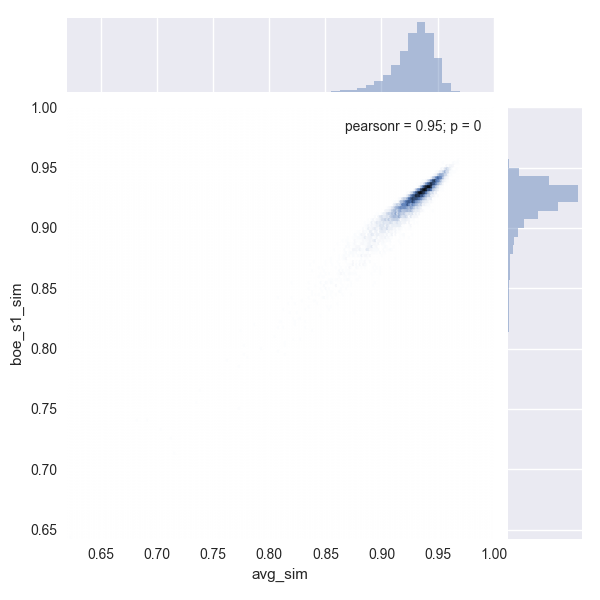

<IPython.core.display.Javascript object>


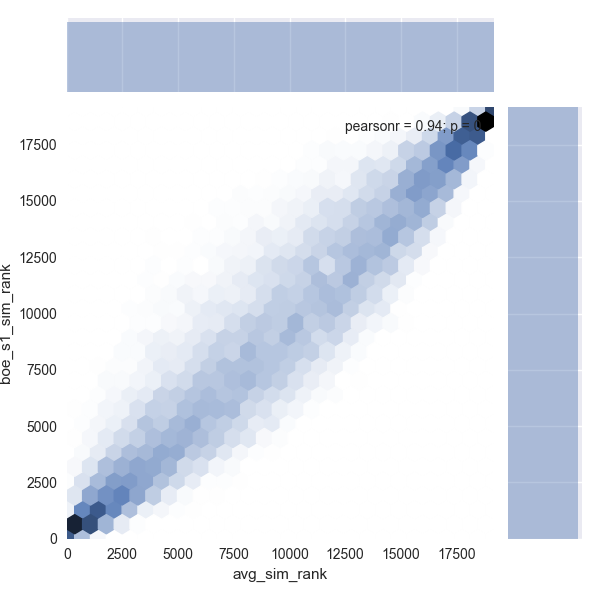

<IPython.core.display.Javascript object>


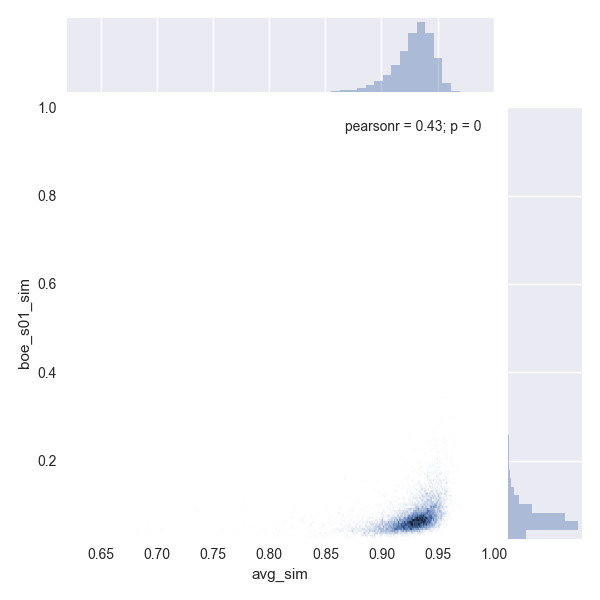

<IPython.core.display.Javascript object>


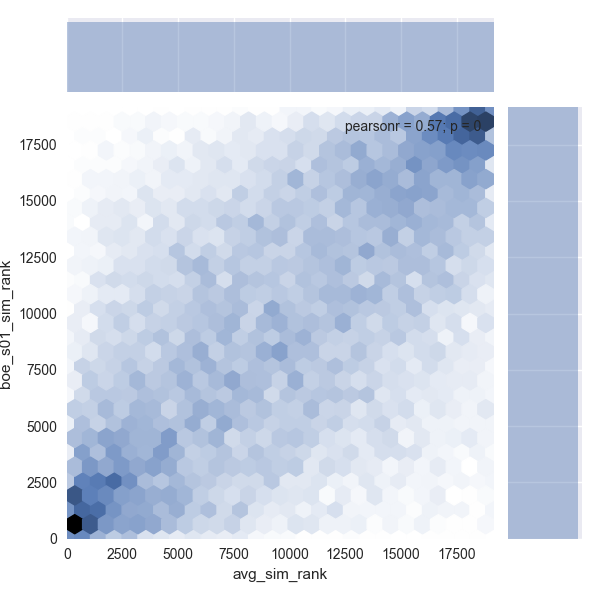

<IPython.core.display.Javascript object>


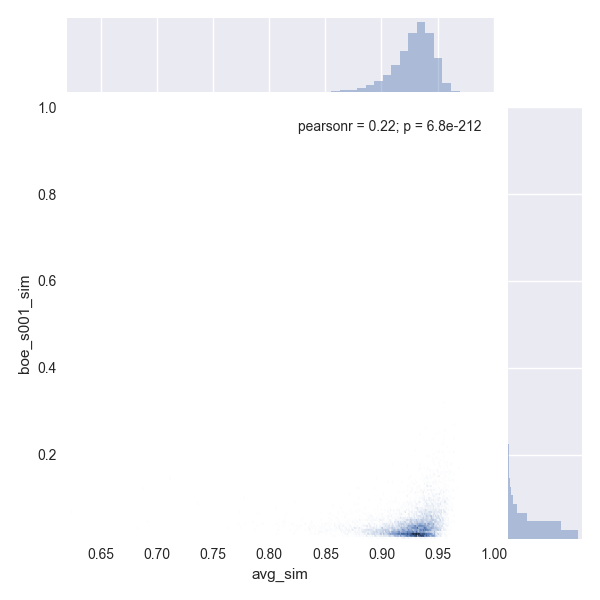

<IPython.core.display.Javascript object>


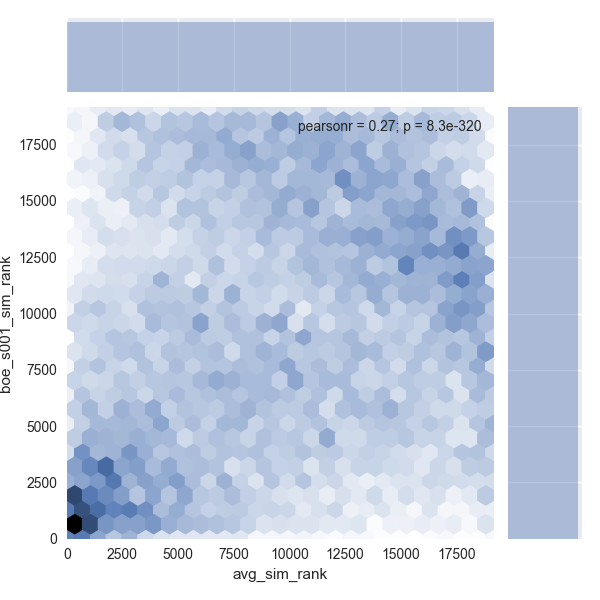

In [51]:
for s in ['s1', 's01', 's001']:
    for suff in ['', '_rank']:
        sb_plot = sb.jointplot('avg_sim{suff}'.format(suff=suff), 'boe_{s}_sim{suff}'.format(s=s, suff=suff), data=df_Q, kind='hex')
        sb_plot.savefig('./avgsim_boe{s}{suff}.png'.format(s=s, suff=suff)) 